<h3>Intro</h3>

This notebook contains the data cleaning methodology for the Bay Area wildfires data. Our goal is to extract the data on fire incidents for 2015-2020 (2015 being prior to the start of the most extreme fire seasons in California), and to clean these data so that they may be linked with our other data sources on the axes of time and location.

In [1]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy
import scipy
from collections import OrderedDict
import reverse_geocoder as rg

Originally, we planned to use a pre-scraped wildfires incidents dataset from Kaggle, but it was missing 2020 and 2019 data, so we went directly to the source of their data, www.fire.ca.gov.

They do not have a documented API, but from a page inspection of https://www.fire.ca.gov/incidents/2020/, we see that they are getting their fire incidents data from an undocumented API.

In [518]:
# Calling this API to get all incidents from 2020 so that we can see what the data will look like
resp2020 = requests.get('https://www.fire.ca.gov/umbraco/Api/IncidentApi/GetIncidents?year=2020')

In [519]:
df_2020 = pd.DataFrame.from_dict(resp2020.json()['Incidents'])
df_2020.head()

,AcresBurned,Active,AdminUnit,AirTankers,ArchiveYear,CalFireIncident,CanonicalUrl,ConditionStatement,ControlStatement,Counties,...,SearchKeywords,Started,Status,StructuresDamaged,StructuresDestroyed,StructuresEvacuated,StructuresThreatened,UniqueId,Updated,WaterTenders
0,86509.0,False,Unified Command Agencies: Santa Cruz Co. Sheri...,NaN,2020,True,/incidents/2020/8/16/czu-lightning-complex-inc...,None,None,"[Santa Cruz, San Mateo]",...,None,2020-08-16T06:41:00Z,Finalized,140.0,1490.0,NaN,NaN,d19ac7c7-c899-4600-82c9-fe24dc29f3c9,2020-09-23T15:43:36.067Z,4.0
1,48088.0,False,CAL FIRE San Benito-Monterey Unit,NaN,2020,True,/incidents/2020/8/16/river-fire/,<p><b>RIVER FIRE UPDATE 9/04/20 7 PM</p></b>\n...,None,[Monterey],...,None,2020-08-16T14:56:54Z,Finalized,13.0,30.0,NaN,NaN,ff4d7735-a5d6-452f-8775-3b208eb046b2,2020-09-04T19:08:39.977Z,0.0
2,29667.0,False,CAL FIRE Fresno-Kings Unit,NaN,2020,True,/incidents/2020/7/13/mineral-fire/,<P>Crews continue with suppression repair and ...,None,[Fresno],...,None,2020-07-13T16:40:36Z,Finalized,NaN,7.0,NaN,NaN,ef5e4d08-bf3f-4df1-90b7-92e4e2a2fc91,2020-07-26T19:40:58.7Z,18.0
3,29570.0,False,"Unified Command: Plumas National Forest, Lasse...",NaN,2020,True,/incidents/2020/8/22/sheep-fire/,None,None,[Plumas],...,None,2020-08-22T22:02:57Z,Finalized,NaN,26.0,NaN,NaN,6edfd658-def5-451c-86bd-83cb2280e34f,2020-09-13T07:53:32.833Z,24.0
4,6905.0,False,CAL FIRE San Benito-Monterey Unit,NaN,2020,True,/incidents/2020/8/18/carmel-fire/,<p><b>CARMEL FIRES UPDATE 9/4/20 7 PM </b></p>...,None,[Monterey],...,None,2020-08-18T14:24:01Z,Finalized,7.0,73.0,NaN,NaN,06f4e066-b0d2-4af9-91a3-518aef4d0197,2020-11-17T15:32:07.273Z,0.0


In [520]:
df_2020.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261 entries, 0 to 260
Data columns (total 40 columns):
AcresBurned             240 non-null float64
Active                  261 non-null bool
AdminUnit               254 non-null object
AirTankers              6 non-null float64
ArchiveYear             261 non-null int64
CalFireIncident         261 non-null bool
CanonicalUrl            261 non-null object
ConditionStatement      29 non-null object
ControlStatement        12 non-null object
Counties                261 non-null object
CountyIds               261 non-null object
CrewsInvolved           30 non-null float64
Dozers                  26 non-null float64
Engines                 36 non-null float64
Extinguished            208 non-null object
Fatalities              3 non-null float64
Featured                261 non-null bool
Final                   261 non-null bool
FuelType                0 non-null object
Helicopters             21 non-null float64
Injuries                13 no

In [521]:
# Lists of all years and fields for which we want to get the fire incidents data for our project

years = [2015, 2016, 2017, 2018, 2019, 2020]
fields = ['AcresBurned', 'Active', 'ArchiveYear', 'Counties', 'Extinguished', 'Fatalities', 'Injuries', 'Latitude', 
          'Longitude', 'Name', 'Started', 'StructuresDamaged', 'StructuresDestroyed', 'UniqueId']

In [522]:
# Defining a function to get all of the fire incidents data from a given year from the API
def get_fire_data(url):
    resp = requests.get(url)
    df = pd.DataFrame.from_dict(resp.json()['Incidents'])
    return df

In [523]:
bay_area_counties = ['Alameda', 'Contra Costa', 'Marin', 'Napa', 'San Mateo',
                     'Santa Clara', 'Solano', 'Sonoma']

fires_df = pd.DataFrame(columns=fields)

# Getting fire incidents data for each relevant year and extracting relevant fields
for year in years:
    yr_df = get_fire_data('https://www.fire.ca.gov/umbraco/Api/IncidentApi/GetIncidents?year='+str(year))[fields]
    
    # converting Counties field to tuple to allow merge
    yr_df['Counties'] = yr_df['Counties'].apply(tuple)
    
    # filling NaNs in Fatalities field with 0.0 
    # (based on the information on the website, this seems like a reasonable assumption)
    yr_df['Fatalities'] = yr_df['Fatalities'].fillna(0.0)
    
    fires_df = pd.merge(fires_df, yr_df, how='outer')

fires_df.head()

,AcresBurned,Active,ArchiveYear,Counties,Extinguished,Fatalities,Injuries,Latitude,Longitude,Name,Started,StructuresDamaged,StructuresDestroyed,UniqueId
0,1388.0,False,2015,(),2015-12-29T10:00:00Z,0.0,NaN,34.31953,-119.34512,Solimar Fire,2015-12-25T22:42:00Z,NaN,NaN,c6f0705e-8bec-4a00-92a7-dc47245de7fa
1,151623.0,False,2015,"(Fresno,)",2015-11-09T12:00:00Z,0.0,NaN,36.87400,-118.90500,Rough Fire,2015-07-31T19:00:00Z,NaN,NaN,8c788c0a-d1fc-46d7-a17c-23f786831f7d
2,77081.0,False,2015,"(Trinity,)",2015-07-31T20:25:00Z,0.0,NaN,0.00000,0.00000,River Complex,2015-07-30T22:30:00Z,NaN,NaN,7c83452f-e6f0-47af-aa25-1d0fff3a594f
3,76067.0,False,2015,(),2015-10-15T19:45:00Z,4.0,0.0,0.00000,0.00000,Valley Fire,2015-09-12T13:24:00Z,NaN,1955.0,77d732e5-1f7d-4f9b-a5f8-269b6f7312c5
4,70868.0,False,2015,(),2015-10-15T19:45:00Z,2.0,1.0,38.32974,-120.70418,Butte Fire,2015-09-09T14:26:00Z,44.0,877.0,13466833-32d1-418b-b145-f7ce1f7bf66e


In [524]:
fires_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1612 entries, 0 to 1611
Data columns (total 14 columns):
AcresBurned            1589 non-null float64
Active                 1612 non-null object
ArchiveYear            1612 non-null int64
Counties               1612 non-null object
Extinguished           1501 non-null object
Fatalities             1612 non-null float64
Injuries               79 non-null float64
Latitude               1612 non-null float64
Longitude              1612 non-null float64
Name                   1612 non-null object
Started                1612 non-null object
StructuresDamaged      71 non-null float64
StructuresDestroyed    152 non-null float64
UniqueId               1612 non-null object
dtypes: float64(7), int64(1), object(6)
memory usage: 188.9+ KB


In [525]:
# We see that some fires have a blank Counties field. We need to get the county name based off the lat/long.

# Fill in the county name (if blank), given a set of coordinates
def fill_county(county, lat, long):
    
    if len(county) > 0:
        return county
        
    else:
        # Reverse Geocoder (rg) gets place name and region given a set of coordinates
        # rg returns a list with one element, which is an OrderedDict
        result = rg.search((lat, long))[0]
        
        # getting value of 'admin2' (i.e. county) from the OrderedDict; returns the name of the county + "County"
        county_orig = result['admin2']
        output = []
    
        # remove the word "County" from the end of the county name
        split_county = county_orig.split()
        rm_county = split_county[:-1]
        county_name = ' '.join([str(elem) for elem in rm_county])
        
        output.append(county_name)
    
        return tuple(output)

In [526]:
# Fill in county names for all fires where Counties field is blank
fires_df['Counties'] = fires_df.apply(lambda x: fill_county(x['Counties'], 
                                                            x['Latitude'], x['Longitude']), axis=1)

In [527]:
fires_df.head(2)

,AcresBurned,Active,ArchiveYear,Counties,Extinguished,Fatalities,Injuries,Latitude,Longitude,Name,Started,StructuresDamaged,StructuresDestroyed,UniqueId
0,1388.0,False,2015,"(Ventura,)",2015-12-29T10:00:00Z,0.0,NaN,34.31953,-119.34512,Solimar Fire,2015-12-25T22:42:00Z,NaN,NaN,c6f0705e-8bec-4a00-92a7-dc47245de7fa
1,151623.0,False,2015,"(Fresno,)",2015-11-09T12:00:00Z,0.0,NaN,36.87400,-118.90500,Rough Fire,2015-07-31T19:00:00Z,NaN,NaN,8c788c0a-d1fc-46d7-a17c-23f786831f7d


In [528]:
# Check whether each fire has at least one value in Counties that is in the Bay Area

bay_area_counties = ['Alameda', 'Contra Costa', 'Marin', 'Napa', 'San Mateo',
                     'Santa Clara', 'Solano', 'Sonoma']

def check_if_bay(counties):
    in_bay = False
    if len(counties)>0:
        for i in counties:
            if i in bay_area_counties:
                in_bay = True
    return in_bay

In [529]:
# New column showing whether or not the fire was in the Bay Area
fires_df['InBay'] = fires_df.apply(lambda x: check_if_bay(x['Counties']), axis=1)

In [530]:
# Extract the data for fires that were in the Bay Area
bay_area_df = fires_df[fires_df['InBay']==True].reset_index()

In [531]:
bay_area_df.head()

,index,AcresBurned,Active,ArchiveYear,Counties,Extinguished,Fatalities,Injuries,Latitude,Longitude,Name,Started,StructuresDamaged,StructuresDestroyed,UniqueId,InBay
0,10,25118.0,False,2015,"(Lake, Napa)",2015-08-25T06:45:00Z,0.0,NaN,38.814250,-122.486732,Jerusalem Fire,2015-08-09T15:34:00Z,NaN,27.0,94a7ae52-fed9-4997-b972-1761aa4b89ca,True
1,21,2700.0,False,2015,"(Alameda,)",2015-08-22T18:30:00Z,0.0,NaN,37.384500,-121.373200,Tesla Fire,2015-08-19T14:45:00Z,NaN,NaN,8fc920eb-ca45-4d77-9a92-1326eca602d6,True
2,37,533.0,False,2015,"(Contra Costa,)",2015-06-25T09:00:00Z,0.0,NaN,37.974123,-121.833751,Loma Fire,2015-06-24T16:15:00Z,NaN,NaN,e7b2df46-649e-4fd9-81c5-daadaa57bc8d,True
3,47,300.0,False,2015,"(Alameda,)",2015-06-06T07:15:00Z,0.0,NaN,0.000000,0.000000,Site Fire,2015-06-05T20:22:00Z,NaN,NaN,186f5cdd-aa7d-4f9e-84ae-83112801c790,True
4,50,242.0,False,2015,"(Alameda,)",2015-05-28T10:30:00Z,0.0,NaN,0.000000,0.000000,Christensen Fire,2015-05-28T17:00:00Z,NaN,NaN,7c162fbf-922c-4128-9e30-a1e8848e15ab,True


In [532]:
bay_area_df.describe()

,index,AcresBurned,ArchiveYear,Fatalities,Injuries,Latitude,Longitude,StructuresDamaged,StructuresDestroyed
count,167.000000,167.000000,167.000000,167.000000,6.000000,167.000000,167.000000,11.000000,19.000000
mean,898.347305,7899.131737,2017.958084,0.191617,2.500000,35.587326,-114.494445,162.545455,571.473684
std,444.432452,43446.193001,1.469994,1.776466,2.073644,9.022053,29.112420,235.786498,1338.315872
min,10.000000,0.000000,2015.000000,0.000000,1.000000,0.000000,-123.247130,1.000000,1.000000
25%,541.000000,30.500000,2017.000000,0.000000,1.000000,37.380905,-122.227335,3.000000,1.000000
50%,983.000000,70.000000,2018.000000,0.000000,1.500000,37.820660,-121.888070,60.000000,27.000000
75%,1271.000000,210.500000,2019.000000,0.000000,3.500000,38.214060,-121.679651,227.000000,298.000000
max,1579.000000,396624.000000,2020.000000,22.000000,6.000000,38.814250,0.000000,783.000000,5636.000000


In [533]:
bay_area_df.isnull().any()

index                  False
AcresBurned            False
Active                 False
ArchiveYear            False
Counties               False
Extinguished            True
Fatalities             False
Injuries                True
Latitude               False
Longitude              False
Name                   False
Started                False
StructuresDamaged       True
StructuresDestroyed     True
UniqueId               False
InBay                  False
dtype: bool

Looking at the original website, it seems reasonable to assume that if Injuries, StructuresDamaged, or StructuresDestroyed is null, that means that there have been no injuries/property damage recorded for the fire incident in question. Therefore, we will replace these nulls with 0.

In [534]:
bay_area_df['Injuries'].fillna(0.0, inplace=True)
bay_area_df['StructuresDamaged'].fillna(0.0, inplace=True)
bay_area_df['StructuresDestroyed'].fillna(0.0, inplace=True)

bay_area_df.head()

,index,AcresBurned,Active,ArchiveYear,Counties,Extinguished,Fatalities,Injuries,Latitude,Longitude,Name,Started,StructuresDamaged,StructuresDestroyed,UniqueId,InBay
0,10,25118.0,False,2015,"(Lake, Napa)",2015-08-25T06:45:00Z,0.0,0.0,38.814250,-122.486732,Jerusalem Fire,2015-08-09T15:34:00Z,0.0,27.0,94a7ae52-fed9-4997-b972-1761aa4b89ca,True
1,21,2700.0,False,2015,"(Alameda,)",2015-08-22T18:30:00Z,0.0,0.0,37.384500,-121.373200,Tesla Fire,2015-08-19T14:45:00Z,0.0,0.0,8fc920eb-ca45-4d77-9a92-1326eca602d6,True
2,37,533.0,False,2015,"(Contra Costa,)",2015-06-25T09:00:00Z,0.0,0.0,37.974123,-121.833751,Loma Fire,2015-06-24T16:15:00Z,0.0,0.0,e7b2df46-649e-4fd9-81c5-daadaa57bc8d,True
3,47,300.0,False,2015,"(Alameda,)",2015-06-06T07:15:00Z,0.0,0.0,0.000000,0.000000,Site Fire,2015-06-05T20:22:00Z,0.0,0.0,186f5cdd-aa7d-4f9e-84ae-83112801c790,True
4,50,242.0,False,2015,"(Alameda,)",2015-05-28T10:30:00Z,0.0,0.0,0.000000,0.000000,Christensen Fire,2015-05-28T17:00:00Z,0.0,0.0,7c162fbf-922c-4128-9e30-a1e8848e15ab,True


Thus, the remaining nulls that we are concerned about are the Extinguished dates. We will first check how many of the fires with nulls Extinguished are still active.

In [535]:
bay_area_df[bay_area_df['Extinguished'].isna()]

,index,AcresBurned,Active,ArchiveYear,Counties,Extinguished,Fatalities,Injuries,Latitude,Longitude,Name,Started,StructuresDamaged,StructuresDestroyed,UniqueId,InBay
103,1108,15.0,False,2019,"(Contra Costa,)",None,0.0,0.0,38.045866,-122.245186,Nustar Fire,2019-10-15T16:17:18Z,0.0,0.0,0baff961-3ce3-45ec-80f1-a72957f2f3f4,True
107,1175,240.0,False,2019,"(Alameda,)",None,0.0,0.0,37.708743,-121.841879,Harte Fire,2019-08-09T15:09:50Z,0.0,0.0,4affde91-31a9-4588-bf14-7201fc5c548b,True
110,1194,183.0,False,2019,"(Solano,)",None,0.0,0.0,38.158333,-122.118889,Marshview Fire,2019-07-24T12:28:45Z,0.0,0.0,f0577ec6-5504-4460-83ce-d9bd91624e0a,True
117,1244,80.0,False,2019,"(Santa Clara,)",None,0.0,0.0,37.433192,-121.807258,Sweigert Fire,2019-07-24T20:01:44Z,0.0,0.0,a8c2bf1e-bb0f-4eec-a435-36d7723dfda6,True
119,1253,67.0,False,2019,"(Marin,)",None,0.0,0.0,37.896231,-122.636471,Muir Fire,2019-10-24T12:15:33Z,0.0,0.0,16b1921b-f753-4a36-85bc-d903555f0af4,True
120,1257,64.0,False,2019,"(Napa,)",None,0.0,0.0,38.481258,-122.143942,Canyon Fire,2019-07-22T15:05:34Z,0.0,0.0,26676376-4e61-4d68-a28f-5fd8b4501acd,True
122,1261,60.0,False,2019,"(Santa Clara,)",None,0.0,0.0,37.219717,-121.761974,Bayliss Fire,2019-08-15T13:44:02Z,0.0,0.0,0deca389-4481-4d91-8765-40caba3ea31c,True
123,1263,58.0,False,2019,"(Contra Costa,)",None,0.0,0.0,37.968494,-121.678172,Sellers Fire,2019-08-07T15:13:52Z,0.0,0.0,e338f506-b9fa-44c0-ae64-324ed0e590d4,True
127,1284,35.0,False,2019,"(Santa Clara,)",None,0.0,0.0,37.034183,-121.455970,Jamieson Fire,2019-08-25T13:06:49Z,0.0,0.0,19343958-2921-41d2-a3f8-501badcd0bee,True
129,1293,30.0,False,2019,"(Solano,)",None,0.0,0.0,38.079444,-122.256111,Mare Fire,2019-09-26T15:29:06Z,0.0,0.0,178b2af3-340c-409d-80e6-21ac119969f0,True


None of the fires with null Extinguished values are still active, indicating that this seems to be accidental missing data rather than missing values because an Extinguished date is not yet applicable.

Dropping these fires would be misleading because they would be left off of our final maps and visualizations, concealing the direct effects of wildfires on our economic variables of interest, and leading to an overexaggeration of the indirect effects of air quality.

It might be acceptable to interpolate the missing values; however, because there are only 13 such values, we will simply use Google to attempt to find a precise Extinguished date for each of these fires.

In [536]:
extinguished_dates = {103: '2019-10-16 04:00',
                     107: '2019-08-10 01:00',
                     110: '2019-07-27 02:00',
                     117: '2019-07-26 01:00',
                     119: '2019-10-26 03:00',
                     120: '2019-07-26 03:00',
                     122: '2019-08-16 02:00',
                     123: '2019-08-08 00:00',
                     127: '2019-08-26 17:00',
                     129: '2019-09-27 01:00',
                     166: '2020-06-04 23:00'}

We were unable to find a conclusive Extinguished date for the California Fire of 2020-07-06 or the Creek Fire of 2020-05-30. We will explore the data further to see whether it would be appropriate to replace these values based on the mean or median burn time of fires. In particular, we want to look at the distributions of burn times for each year vs. the 6-year period, and see whether either the mean/median of 2020 data only, or the mean/median of all the data, might be appropriate to use to fill the remaining nulls.

In [537]:
# Fill in our researched values for the missing Extinguished values in bay_area_df
for i in extinguished_dates:
    bay_area_df.iloc[i, bay_area_df.columns.get_loc('Extinguished')] = pd.to_datetime(extinguished_dates[i])

In [538]:
bay_area_df[bay_area_df['Extinguished'].isna()]

,index,AcresBurned,Active,ArchiveYear,Counties,Extinguished,Fatalities,Injuries,Latitude,Longitude,Name,Started,StructuresDamaged,StructuresDestroyed,UniqueId,InBay
155,1480,298.0,False,2020,"(Contra Costa,)",None,0.0,0.0,38.02996,-122.25471,California Fire,2020-07-06T15:32:26Z,0.0,0.0,fc988bbb-4f93-478d-8a6c-b1be51d436c7,True
162,1546,60.0,False,2020,"(Contra Costa,)",None,0.0,0.0,35.99940,-86.86160,Creek Fire,2020-05-30T17:48:59Z,0.0,0.0,0e1e69d4-cb59-4228-8c55-f18e6b5ad71c,True


In [539]:
# Convert Started and Extinguished dates to datetime
bay_area_df['Started_datetime'] = pd.to_datetime(bay_area_df['Started'])
bay_area_df['Extinguished_datetime'] = pd.to_datetime(bay_area_df['Extinguished'])

In [540]:
# Add column for burn time
bay_area_df['Burn_time'] = (bay_area_df['Extinguished_datetime'] - bay_area_df['Started_datetime'])

In [541]:
bay_area_df['Burn_time'].describe()

count                          165
mean      181 days 22:30:34.353115
std      1390 days 08:16:47.024950
min              -1 days +17:15:23
25%                1 days 01:40:05
50%               13 days 21:33:00
75%              159 days 17:00:00
max            17900 days 17:22:00
Name: Burn_time, dtype: object

We notice that there is at least one fire for which the extinguished date is reported as earlier than the started date. We will investigate these value(s), since they are physically impossible.

In [542]:
bay_area_df.sort_values(by=['Burn_time']).head(10)

,index,AcresBurned,Active,ArchiveYear,Counties,Extinguished,Fatalities,Injuries,Latitude,Longitude,Name,Started,StructuresDamaged,StructuresDestroyed,UniqueId,InBay,Started_datetime,Extinguished_datetime,Burn_time
159,1538,75.0,False,2020,"(Contra Costa,)",2020-07-20T11:20:00Z,0.0,0.0,37.977309,-121.620238,Holland Fire,2020-07-20T18:04:37Z,0.0,0.0,cac8f4bf-d269-4f13-b59c-07670b34f81f,True,2020-07-20 18:04:37.000,2020-07-20 11:20:00,-1 days +17:15:23
4,50,242.0,False,2015,"(Alameda,)",2015-05-28T10:30:00Z,0.0,0.0,0.000000,0.000000,Christensen Fire,2015-05-28T17:00:00Z,0.0,0.0,7c162fbf-922c-4128-9e30-a1e8848e15ab,True,2015-05-28 17:00:00.000,2015-05-28 10:30:00,-1 days +17:30:00
132,1308,25.0,False,2019,"(Alameda,)",2019-07-05T03:20:00Z,0.0,0.0,37.469000,-121.369700,Bikeway Fire,2019-07-05T09:46:01.973Z,0.0,0.0,65e8fbe1-5300-4c90-9f48-0e7bfe55b1bc,True,2019-07-05 09:46:01.973,2019-07-05 03:20:00,-1 days +17:33:58.027000
158,1537,79.0,False,2020,"(Solano,)",2020-06-05T15:10:00Z,0.0,0.0,38.196893,-122.156313,McGary Fire,2020-06-05T17:09:00Z,0.0,0.0,5698ae57-d61f-421b-8b75-623e9aa6debb,True,2020-06-05 17:09:00.000,2020-06-05 15:10:00,-1 days +22:01:00
136,1322,19.0,False,2019,"(Alameda,)",2019-08-31T12:50:00Z,0.0,0.0,37.718636,-121.657011,Carroll Fire,2019-08-31T12:55:15Z,0.0,0.0,40ce99a7-fbca-4b41-b3bf-e2f863fdcc7e,True,2019-08-31 12:55:15.000,2019-08-31 12:50:00,-1 days +23:54:45
131,1299,29.0,False,2019,"(Santa Clara,)",2019-10-07T09:58:00Z,0.0,0.0,37.066483,-121.219163,Point Fire,2019-10-07T09:58:51.763Z,0.0,0.0,25e80e7d-5790-4192-9cf0-a190f36158f0,True,2019-10-07 09:58:51.763,2019-10-07 09:58:00,-1 days +23:59:08.237000
138,1334,12.0,False,2019,"(Alameda,)",2019-10-08T17:51:00Z,0.0,0.0,37.606000,-121.853000,Little Fire,2019-10-08T17:25:12Z,0.0,0.0,a87ab8be-3da9-4cb0-a72c-5125acc001ef,True,2019-10-08 17:25:12.000,2019-10-08 17:51:00,00:25:48
114,1209,139.0,False,2019,"(Alameda,)",2019-08-21T18:27:00Z,0.0,0.0,37.717340,-121.558670,Patterson Fire,2019-08-21T17:56:05Z,0.0,0.0,d35fa87b-0f19-4dd8-8739-4bdbc92d1361,True,2019-08-21 17:56:05.000,2019-08-21 18:27:00,00:30:55
102,1107,22.0,False,2019,"(Alameda,)",2019-07-12T19:20:00Z,0.0,0.0,37.093243,-121.586846,Mid Fire,2019-07-12T18:40:09Z,0.0,0.0,3fc9ae75-8844-43a5-8330-6956cdb6e3a7,True,2019-07-12 18:40:09.000,2019-07-12 19:20:00,00:39:51
133,1310,24.0,False,2019,"(Contra Costa,)",2019-07-05T14:58:00Z,0.0,0.0,37.998370,-122.162010,Fellow Fire,2019-07-05T13:33:56Z,0.0,0.0,bc3e7037-5022-4e6a-8a1f-925c7e9aafc8,True,2019-07-05 13:33:56.000,2019-07-05 14:58:00,01:24:04


All of the fires with negative burn times have both Started and Extinguished dates on the same day, with less than an hour offset in most cases. Based on this observation, we suspect that, rather than data entry errors, these were probably mostly very short-burning fires, and ended up with negative burn times due to imprecise measurements or recording of started and extinguished times. Because our data will be on a day-by-day level (at the most granular), we will treat these fires as having occurred on the single day in which both their started and extinguished datetimes occur.

In [543]:
bay_area_df.sort_values(by=['Started']).head()

,index,AcresBurned,Active,ArchiveYear,Counties,Extinguished,Fatalities,Injuries,Latitude,Longitude,Name,Started,StructuresDamaged,StructuresDestroyed,UniqueId,InBay,Started_datetime,Extinguished_datetime,Burn_time
82,979,45.0,False,2018,"(Marin,)",2019-01-04T09:22:00Z,0.0,0.0,38.07135,-122.76751,Bridge Fire,1969-12-31T16:00:00Z,0.0,0.0,49232e73-c3ba-4dc3-b673-b973a918fa7c,True,1969-12-31 16:00:00,2019-01-04 09:22:00,17900 days 17:22:00
4,50,242.0,False,2015,"(Alameda,)",2015-05-28T10:30:00Z,0.0,0.0,0.00000,0.00000,Christensen Fire,2015-05-28T17:00:00Z,0.0,0.0,7c162fbf-922c-4128-9e30-a1e8848e15ab,True,2015-05-28 17:00:00,2015-05-28 10:30:00,-1 days +17:30:00
3,47,300.0,False,2015,"(Alameda,)",2015-06-06T07:15:00Z,0.0,0.0,0.00000,0.00000,Site Fire,2015-06-05T20:22:00Z,0.0,0.0,186f5cdd-aa7d-4f9e-84ae-83112801c790,True,2015-06-05 20:22:00,2015-06-06 07:15:00,0 days 10:53:00
13,130,36.0,False,2015,"(Napa,)",2015-06-10T09:45:00Z,0.0,0.0,0.00000,0.00000,Garage Fire,2015-06-09T15:23:00Z,0.0,0.0,2513b19f-3509-4e0f-8d87-85785061af02,True,2015-06-09 15:23:00,2015-06-10 09:45:00,0 days 18:22:00
12,128,38.0,False,2015,"(Napa,)",2015-06-17T13:10:00Z,0.0,0.0,38.52870,-122.34150,Chiles Fire,2015-06-16T14:27:00Z,0.0,0.0,e3272697-2587-45ac-b525-76b85fabaa90,True,2015-06-16 14:27:00,2015-06-17 13:10:00,0 days 22:43:00


We see that there's one weird row with Started date in 1969. There's no way to know the reason for that anomaly, so it is safest to drop that row.

In [544]:
_ = bay_area_df.drop([82], inplace=True)

In [545]:
# creating a column with burn time in hours to make graphing and manipulation easier
bay_area_df['Burn_time_hrs'] = bay_area_df['Burn_time'] / pd.Timedelta(hours=1)

In [546]:
bay_area_df.sort_values(by=['Started']).head()

,index,AcresBurned,Active,ArchiveYear,Counties,Extinguished,Fatalities,Injuries,Latitude,Longitude,Name,Started,StructuresDamaged,StructuresDestroyed,UniqueId,InBay,Started_datetime,Extinguished_datetime,Burn_time,Burn_time_hrs
4,50,242.0,False,2015,"(Alameda,)",2015-05-28T10:30:00Z,0.0,0.0,0.000000,0.000000,Christensen Fire,2015-05-28T17:00:00Z,0.0,0.0,7c162fbf-922c-4128-9e30-a1e8848e15ab,True,2015-05-28 17:00:00,2015-05-28 10:30:00,-1 days +17:30:00,-6.500000
3,47,300.0,False,2015,"(Alameda,)",2015-06-06T07:15:00Z,0.0,0.0,0.000000,0.000000,Site Fire,2015-06-05T20:22:00Z,0.0,0.0,186f5cdd-aa7d-4f9e-84ae-83112801c790,True,2015-06-05 20:22:00,2015-06-06 07:15:00,10:53:00,10.883333
13,130,36.0,False,2015,"(Napa,)",2015-06-10T09:45:00Z,0.0,0.0,0.000000,0.000000,Garage Fire,2015-06-09T15:23:00Z,0.0,0.0,2513b19f-3509-4e0f-8d87-85785061af02,True,2015-06-09 15:23:00,2015-06-10 09:45:00,18:22:00,18.366667
12,128,38.0,False,2015,"(Napa,)",2015-06-17T13:10:00Z,0.0,0.0,38.528700,-122.341500,Chiles Fire,2015-06-16T14:27:00Z,0.0,0.0,e3272697-2587-45ac-b525-76b85fabaa90,True,2015-06-16 14:27:00,2015-06-17 13:10:00,22:43:00,22.716667
2,37,533.0,False,2015,"(Contra Costa,)",2015-06-25T09:00:00Z,0.0,0.0,37.974123,-121.833751,Loma Fire,2015-06-24T16:15:00Z,0.0,0.0,e7b2df46-649e-4fd9-81c5-daadaa57bc8d,True,2015-06-24 16:15:00,2015-06-25 09:00:00,16:45:00,16.750000


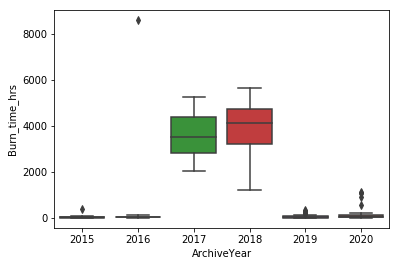

In [547]:
sns.boxplot(x='ArchiveYear',y='Burn_time_hrs',data=bay_area_df)

In [548]:
bay_area_df.groupby('ArchiveYear').count()

,index,AcresBurned,Active,Counties,Extinguished,Fatalities,Injuries,Latitude,Longitude,Name,Started,StructuresDamaged,StructuresDestroyed,UniqueId,InBay,Started_datetime,Extinguished_datetime,Burn_time,Burn_time_hrs
ArchiveYear,,,,,,,,,,,,,,,,,,,
2015,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15
2016,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10
2017,36,36,36,36,36,36,36,36,36,36,36,36,36,36,36,36,36,36,36
2018,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38
2019,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40
2020,27,27,27,27,25,27,27,27,27,27,27,27,27,27,27,27,25,25,25


In [549]:
bay_area_df[bay_area_df['ArchiveYear']==2017].head()

,index,AcresBurned,Active,ArchiveYear,Counties,Extinguished,Fatalities,Injuries,Latitude,Longitude,Name,Started,StructuresDamaged,StructuresDestroyed,UniqueId,InBay,Started_datetime,Extinguished_datetime,Burn_time,Burn_time_hrs
25,347,56556.0,False,2017,"(Napa, Sonoma)",2018-02-09T09:30:00Z,3.0,0.0,38.40410,-122.52090,Nuns / Adobe / Norrbom/ Pressley / Partrick Fi...,2017-10-08T22:00:00Z,172.0,1355.0,be79d28c-767d-4a0d-b168-e86a5842004f,True,2017-10-08 22:00:00,2018-02-09 09:30:00,123 days 11:30:00,2963.500000
26,348,51624.0,False,2017,"(Napa, Solano)",2018-02-09T09:37:00Z,6.0,0.0,38.39206,-122.24367,Atlas Fire (Southern LNU Complex),2017-10-08T21:52:00Z,783.0,120.0,676946dc-1b38-4a09-9bbe-9ce638cfed52,True,2017-10-08 21:52:00,2018-02-09 09:37:00,123 days 11:45:00,2963.750000
27,351,36807.0,False,2017,"(Napa, Sonoma)",2018-02-09T09:27:00Z,22.0,0.0,38.60895,-122.62879,Tubbs Fire (Central LNU Complex),2017-10-08T21:45:00Z,317.0,5636.0,82c2aafa-ef04-49f0-a172-0dfa8a15582e,True,2017-10-08 21:45:00,2018-02-09 09:27:00,123 days 11:42:00,2963.700000
28,360,17357.0,False,2017,"(Sonoma,)",2018-02-09T09:32:00Z,0.0,0.0,38.76549,-122.90939,Pocket Fire (Central LNU Complex),2017-10-09T03:30:00Z,2.0,6.0,0de36981-b31f-45c7-befd-1596f982e7db,True,2017-10-09 03:30:00,2018-02-09 09:32:00,123 days 06:02:00,2958.033333
29,397,1868.0,False,2017,"(Sonoma,)",2018-01-09T13:33:00Z,0.0,0.0,0.00000,0.00000,Adobe Fire (Central LNU Complex),2017-10-09T01:00:00Z,0.0,0.0,9a5c9879-2e18-41a4-88d6-2360203dae79,True,2017-10-09 01:00:00,2018-01-09 13:33:00,92 days 12:33:00,2220.550000


In [550]:
bay_area_df[bay_area_df['ArchiveYear']==2016].sort_values(by='Burn_time', ascending=False).head()

,index,AcresBurned,Active,ArchiveYear,Counties,Extinguished,Fatalities,Injuries,Latitude,Longitude,Name,Started,StructuresDamaged,StructuresDestroyed,UniqueId,InBay,Started_datetime,Extinguished_datetime,Burn_time,Burn_time_hrs
15,174,4474.0,False,2016,"(Santa Clara,)",2017-09-19T10:30:00Z,0.0,0.0,37.10632,-121.85318,Loma Fire,2016-09-26T14:42:00Z,1.0,28.0,2dfac408-d2ab-4ff9-94aa-91be9d07bb59,True,2016-09-26 14:42:00,2017-09-19 10:30:00,357 days 19:48:00,8587.800000
16,189,1547.0,False,2016,"(Sonoma,)",2016-09-29T17:00:00Z,0.0,2.0,38.80017,-122.82895,Sawmill Fire,2016-09-25T10:43:00Z,0.0,0.0,8d9b87e4-6fdb-49e4-ba6d-be85ffd6b222,True,2016-09-25 10:43:00,2016-09-29 17:00:00,4 days 06:17:00,102.283333
24,318,25.0,False,2016,"(Santa Clara,)",2016-08-14T19:50:00Z,0.0,0.0,37.06531,-121.68577,Oak Fire,2016-08-12T16:00:00Z,0.0,0.0,b82b0e22-4155-43dd-ac33-1da015b6d3d2,True,2016-08-12 16:00:00,2016-08-14 19:50:00,2 days 03:50:00,51.833333
20,274,65.0,False,2016,"(Napa,)",2016-10-12T18:00:00Z,0.0,0.0,38.40958,-122.43172,Creek Fire,2016-10-10T16:13:00Z,0.0,0.0,3135c367-1274-4cc4-9152-661f6fd7707e,True,2016-10-10 16:13:00,2016-10-12 18:00:00,2 days 01:47:00,49.783333
19,248,100.0,False,2016,"(Santa Clara,)",2016-08-18T19:50:00Z,0.0,0.0,0.00000,0.00000,Bailey Fire,2016-08-17T15:19:00Z,0.0,0.0,40dec759-8a09-439c-8c95-14b4a248c033,True,2016-08-17 15:19:00,2016-08-18 19:50:00,1 days 04:31:00,28.516667


We see from the the charts and particularly the boxplots that, in 2017 and 2018, the shape of the data looks very different from the other years, with fires burning for much longer on average. Though this appears at first sight to be a very extreme difference, a spot check of fire incidents from 2017 reveals that there were indeed a significant number of fires that burned for three months or more in that year; according to Wikipedia, the 2017 fire season was one of the most severe and deadliest fire events in the US in the past century.

The other feature of interest from the boxplots is the extreme outlier in 2016. This data point corresponds to the Loma Fire, which several news sources confirm was contained on 2016-10-12, not 2017-09-19, as is listed in the df. We are unsure of the source of this discrepancy, but we will change the Extinguished value to reflect the true timeline.

In [551]:
bay_area_df.iloc[15, bay_area_df.columns.get_loc('Extinguished')] = pd.to_datetime('2016-10-12')

In [552]:
bay_area_df[bay_area_df['ArchiveYear']==2016].sort_values(by='Burn_time', ascending=False).head(2)

,index,AcresBurned,Active,ArchiveYear,Counties,Extinguished,Fatalities,Injuries,Latitude,Longitude,Name,Started,StructuresDamaged,StructuresDestroyed,UniqueId,InBay,Started_datetime,Extinguished_datetime,Burn_time,Burn_time_hrs
15,174,4474.0,False,2016,"(Santa Clara,)",2016-10-12 00:00:00,0.0,0.0,37.10632,-121.85318,Loma Fire,2016-09-26T14:42:00Z,1.0,28.0,2dfac408-d2ab-4ff9-94aa-91be9d07bb59,True,2016-09-26 14:42:00,2017-09-19 10:30:00,357 days 19:48:00,8587.800000
16,189,1547.0,False,2016,"(Sonoma,)",2016-09-29T17:00:00Z,0.0,2.0,38.80017,-122.82895,Sawmill Fire,2016-09-25T10:43:00Z,0.0,0.0,8d9b87e4-6fdb-49e4-ba6d-be85ffd6b222,True,2016-09-25 10:43:00,2016-09-29 17:00:00,4 days 06:17:00,102.283333


Now that we've seen that the distribution of the burn times is so different from year to year, we will replace the remaining two NaNs in Extinguished (which are both from 2020) by using the median burn time from 2020. 

In [553]:
bay_area_df[bay_area_df['ArchiveYear']==2020]['Burn_time'].describe()

count                         25
mean      9 days 06:29:49.040000
std      15 days 20:00:48.482384
min            -1 days +17:15:23
25%              0 days 14:59:35
50%              2 days 01:44:17
75%              5 days 02:23:52
max             46 days 03:58:00
Name: Burn_time, dtype: object

In [554]:
bay_area_df[bay_area_df['Burn_time'].isna()]

,index,AcresBurned,Active,ArchiveYear,Counties,Extinguished,Fatalities,Injuries,Latitude,Longitude,Name,Started,StructuresDamaged,StructuresDestroyed,UniqueId,InBay,Started_datetime,Extinguished_datetime,Burn_time,Burn_time_hrs
155,1480,298.0,False,2020,"(Contra Costa,)",None,0.0,0.0,38.02996,-122.25471,California Fire,2020-07-06T15:32:26Z,0.0,0.0,fc988bbb-4f93-478d-8a6c-b1be51d436c7,True,2020-07-06 15:32:26,NaT,NaT,NaN
162,1546,60.0,False,2020,"(Contra Costa,)",None,0.0,0.0,35.99940,-86.86160,Creek Fire,2020-05-30T17:48:59Z,0.0,0.0,0e1e69d4-cb59-4228-8c55-f18e6b5ad71c,True,2020-05-30 17:48:59,NaT,NaT,NaN


The median burn time in 2020 is 2 days 01:44:17. We add this value to each of the started dates to calculate an estimated Extinguished date.

In [555]:
bay_area_df.set_index('UniqueId', inplace=True)
bay_area_df.head(2)

,index,AcresBurned,Active,ArchiveYear,Counties,Extinguished,Fatalities,Injuries,Latitude,Longitude,Name,Started,StructuresDamaged,StructuresDestroyed,InBay,Started_datetime,Extinguished_datetime,Burn_time,Burn_time_hrs
UniqueId,,,,,,,,,,,,,,,,,,,
94a7ae52-fed9-4997-b972-1761aa4b89ca,10,25118.0,False,2015,"(Lake, Napa)",2015-08-25T06:45:00Z,0.0,0.0,38.81425,-122.486732,Jerusalem Fire,2015-08-09T15:34:00Z,0.0,27.0,True,2015-08-09 15:34:00,2015-08-25 06:45:00,15 days 15:11:00,375.183333
8fc920eb-ca45-4d77-9a92-1326eca602d6,21,2700.0,False,2015,"(Alameda,)",2015-08-22T18:30:00Z,0.0,0.0,37.38450,-121.373200,Tesla Fire,2015-08-19T14:45:00Z,0.0,0.0,True,2015-08-19 14:45:00,2015-08-22 18:30:00,3 days 03:45:00,75.750000


In [556]:
med_time = bay_area_df[bay_area_df['ArchiveYear']==2020]['Burn_time'].median()

In [557]:
est_dates = {'fc988bbb-4f93-478d-8a6c-b1be51d436c7': str(bay_area_df['Started_datetime']['fc988bbb-4f93-478d-8a6c-b1be51d436c7'] + med_time),
            '0e1e69d4-cb59-4228-8c55-f18e6b5ad71c': str(bay_area_df['Started_datetime']['0e1e69d4-cb59-4228-8c55-f18e6b5ad71c'] + med_time)}

In [558]:
for i in est_dates:
    bay_area_df.loc[i, 'Extinguished'] = est_dates[i]

In [559]:
# Calculating Extinguished_datetime, Burn_time, and Burn_time_hrs again to update according to these changes
bay_area_df['Extinguished_datetime'] = pd.to_datetime(bay_area_df['Extinguished'])
bay_area_df['Burn_time'] = (bay_area_df['Extinguished_datetime'] - bay_area_df['Started_datetime'])
bay_area_df['Burn_time_hrs'] = bay_area_df['Burn_time'] / pd.Timedelta(hours=1)

In [560]:
bay_area_df.isnull().any()

index                    False
AcresBurned              False
Active                   False
ArchiveYear              False
Counties                 False
Extinguished             False
Fatalities               False
Injuries                 False
Latitude                 False
Longitude                False
Name                     False
Started                  False
StructuresDamaged        False
StructuresDestroyed      False
InBay                    False
Started_datetime         False
Extinguished_datetime    False
Burn_time                False
Burn_time_hrs            False
dtype: bool

Now that we've addressed the null values, we also want to look at how the severity of the fires has evolved over time. We will use acres burned as a proxy for severity for now; however, we are considering incorporating fatalities and/or property damage while creating a measure of severity that will be displayed in our final visualizations.

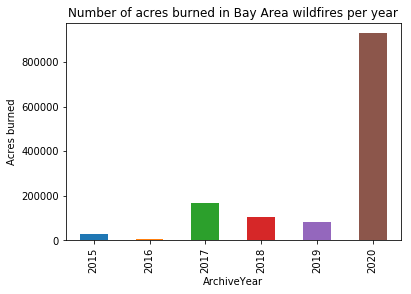

In [561]:
# creating graph of acres burned per year
bay_area_df.groupby('ArchiveYear')['AcresBurned'].sum().plot.bar()
plt.ylabel('Acres burned')
plt.title('Number of acres burned in Bay Area wildfires per year')
plt.show()

From this plot, we see that although the burn time of fires in 2017 and 2018 was much longer than in other years, the acres burned in 2020 has been by far the greatest, indicating that the wildfires have affected a much larger area rather than being concentrated in smaller areas.

<h3>Conclusions</h3>

We have now dealt with nulls, addressed outliers, and ensured that this dataset can easily be linked to others by standardizing the date fields to datetime and the location fields to county. Now that we have the cleaned data for Bay Area wildfires in 2015-2020, we will be able to begin to investigate potential correlations between wildfire occurrence/severity and variables such as frequency of travel and, of course, air quality. Looking ahead to the final visualizations and dashboard, the most important function of the wildfires dataset will be to allow us to indicate to users when and where an active fire was present, so that the direct effects of the fire may be taken into account when considering any changes in mobility or tourism. Being able to localize each fire to its lat/long or, at least, its county, and knowing the days on which it was active, will be crucial for our visualizations; these data, having been appropriately cleaned, are now ready to be used for these purposes.

Our next steps will be to continue with exploratory data analysis, particularly looking into differences across counties, and perhaps also patterns in the fire season itself (e.g., has the length of the fire season increased over time?). We will also start investigating potential correlations between the fires data and our other datasets as a preliminary step to explorations of modeling.